# Random forest

In [1]:
from Functions.Common_functions import *
import pandas as pd

### Load data

In [2]:
dataset_df = formate_dataset()
dataset_df.head()

Surface area  Wall area Roof area Overall height Glazing area GAD : 0  \
0     -1.59779  -0.269786  -1.42786              1     -1.64028       1   
1     -1.71823  -0.422547  -1.47112              1     -1.83179       1   
2     -1.75999  -0.340612  -1.55169              1     -1.76649       1   
3     -1.72899  -0.581134  -1.40454              1     -1.76117       1   
4     -1.34281 -0.0477237  -1.28699              1     -1.81079       1   

  GAD : 1 GAD : 2 GAD : 3 GAD : 4 GAD : 5 East North South West   Energy  \
0       0       0       0       0       0    0     1     0    0  34.2639   
1       0       0       0       0       0    1     0     0    0  34.5898   
2       0       0       0       0       0    0     0     1    0   38.778   
3       0       0       0       0       0    0     0     0    1  37.9478   
4       0       0       0       0       0    0     1     0    0  47.6759   

  Energy efficiency  
0                 B  
1                 B  
2                 C  
3                 C  
4                 D

### Create test set

In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, y_train_r, y_test_r = train_test_split(dataset_df[dataset_df.columns[0:15]], dataset_df['Energy'], test_size=0.20, random_state=42)
_, _, y_train_b, y_test_b = train_test_split(dataset_df[dataset_df.columns[0:15]], dataset_df['Energy efficiency'], test_size=0.20, random_state=42) 

## Random forest algorithm

### First technic : keep full treesfor each samples limited by a minimal observation per leaf ( 5 by default).

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

random_forest = RandomForestClassifier(max_depth=None, oob_score=True, max_features='sqrt', n_jobs=-1)
clf_1 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample', None),
                               'min_samples_leaf': np.arange(1,7)})

clf_1.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'class_weight': ('balanced', 'balanced_subsample',
                                          None),
                         'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6])})

In [5]:
clf_1.best_params_

{'class_weight': None, 'criterion': 'entropy', 'min_samples_leaf': 5}

In [6]:
clf_1.best_estimator_.oob_score_

0.5960912052117264

In [7]:
clf_1.best_estimator_.score(X_test, y_test_b)

0.6363636363636364

### Second technic : build a tree with a limited depth (q)

In [8]:
q = [3, 4, 5, 6, 7]

clf_2 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample'),
                               'max_depth': q})

clf_2.fit(X_train, y_train_b)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt', n_jobs=-1,
                                              oob_score=True),
             param_grid={'class_weight': ('balanced', 'balanced_subsample'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 4, 5, 6, 7]})

In [9]:
clf_2.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7}

In [10]:
clf_2.best_estimator_.oob_score_

0.6107491856677525

In [11]:
clf_2.best_estimator_.score(X_test, y_test_b)

0.6363636363636364

### Third technic : build the full tree and pruning it with cross validation

In [ ]:
clf_3 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample'),
                               'ccp_alpha': np.linspace(start=0, stop=0.02, num=50)})

clf_3.fit(X_train, y_train_b)

In [27]:
clf_3.best_params_

{'ccp_alpha': 0.00040816326530612246,
 'class_weight': None,
 'criterion': 'gini'}

In [28]:
clf_3.best_estimator_.oob_score_

0.6205211726384365

In this case, the third technic works better so we are going to test and evaluate this model.

#### Feature importance

In [15]:
ft_importance = clf_3.best_estimator_.feature_importances_
columns_X = X_train.columns
pd.DataFrame(data= {'Feature': columns_X, 'Importance': ft_importance}).sort_values('Importance', ascending=False)

Feature  Importance
0     Surface area    0.239351
4     Glazing area    0.190662
2        Roof area    0.184488
1        Wall area    0.170557
3   Overall height    0.096030
5          GAD : 0    0.021033
10         GAD : 5    0.013339
6          GAD : 1    0.011687
7          GAD : 2    0.011556
14            West    0.011090
8          GAD : 3    0.010821
12           North    0.010343
13           South    0.010267
11            East    0.010025
9          GAD : 4    0.008750

With this mist of feature importance, we can deduct the model does not take the one hot encoded features into account.

### Test

In [29]:
clf_3.best_estimator_.score(X_test, y_test_b)

0.6168831168831169

In [30]:
from sklearn.metrics import classification_report

y_test_pred = clf_3.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.761     0.897     0.824        39
           B      0.133     0.143     0.138        14
           C      0.714     0.455     0.556        22
           D      0.714     0.714     0.714        14
           E      0.667     0.640     0.653        25
           F      0.480     0.500     0.490        24
           G      0.625     0.625     0.625        16

    accuracy                          0.617       154
   macro avg      0.585     0.568     0.571       154
weighted avg      0.620     0.617     0.613       154



### Errors analyser

<Figure size 360x360 with 0 Axes>

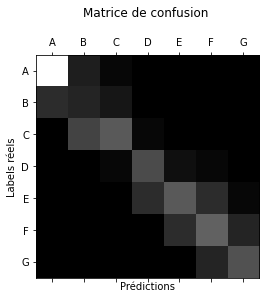

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from Functions.Classification_Functions import *

conf_mx = compute_conf_matrix(estimator=clf_3.best_estimator_, X=X_test, y=y_test_b)
display_conf_matrix(conf_mx)

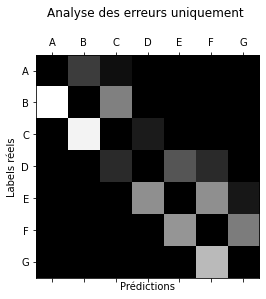

In [19]:
plot_error_analysis(conf_mx)

## Random forest with duplication

#### Resampling data

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled_b = ros.fit_resample(X= X_train, y=y_train_b)

<AxesSubplot:>

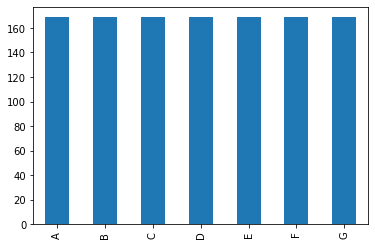

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
y_resampled_b.value_counts().sort_index().plot.bar()

### Naive resampling

In [22]:
import warnings
warnings.filterwarnings('ignore')

clf_3 = GridSearchCV(estimator=random_forest, 
                   param_grid={'criterion': ('gini', 'entropy'),
                               'class_weight': ('balanced', 'balanced_subsample', None),
                               'ccp_alpha': np.linspace(start=0, stop=0.02, num=50)},
                    scoring='f1_macro',
                    cv=3)

clf_3.fit(X_resampled, y_resampled_b)
print(clf_3.best_params_)


{'ccp_alpha': 0.0024489795918367346, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}


In [23]:
from sklearn.metrics import classification_report

y_test_pred = clf_3.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.756     0.872     0.810        39
           B      0.200     0.214     0.207        14
           C      0.733     0.500     0.595        22
           D      0.769     0.714     0.741        14
           E      0.667     0.640     0.653        25
           F      0.458     0.458     0.458        24
           G      0.556     0.625     0.588        16

    accuracy                          0.617       154
   macro avg      0.591     0.575     0.579       154
weighted avg      0.622     0.617     0.615       154



### SMOTE

In [24]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

model = Pipeline([
        ('sampling', SMOTE(random_state=12)),
        ('clf', RandomForestClassifier())
    ])

grid = GridSearchCV(model, estimator=RandomForestClassifier(),
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__class_weight': ('balanced', 'balanced_subsample', None),
                         'clf__ccp_alpha': np.linspace(start=0, stop=0.02, num=50)},
                    scoring='f1_macro',
                    cv=3)

grid.fit(X_train, y_train_b)
print(grid.best_params_)
grid.best_estimator_.score(X_test, y_test_b)

{'clf__ccp_alpha': 0.0069387755102040816, 'clf__class_weight': None, 'clf__criterion': 'entropy'}


0.6168831168831169

In [25]:
from sklearn.metrics import classification_report

y_test_pred = grid.best_estimator_.predict(X_test)
# Print the precision and recall, among other metrics
print(classification_report(y_test_b, y_test_pred, digits=3))

              precision    recall  f1-score   support

           A      0.825     0.846     0.835        39
           B      0.200     0.286     0.235        14
           C      0.667     0.455     0.541        22
           D      0.667     0.714     0.690        14
           E      0.609     0.560     0.583        25
           F      0.542     0.542     0.542        24
           G      0.647     0.688     0.667        16

    accuracy                          0.617       154
   macro avg      0.594     0.584     0.585       154
weighted avg      0.633     0.617     0.621       154



This technics of oversampling did not work with the random forest model.